Recreating the Flip Flop task from the following [paper](https://direct.mit.edu/neco/article/25/3/626/7854/Opening-the-Black-Box-Low-Dimensional-Dynamics-in). The goal is to recreate it first using Gradient Descent (GD) to train the RNN, then using the Exponentiated Gradient (EG) method, and analyse any difference of results.

To directly test produce the results, go to fixed-point-finder/examples/torch and run python run_FlipFlop.py

In this notebook the aim is to recreate everything from "scratch". The key steps will involve: 
DONE - Training the RNN
DONE - Generating the data to train / test the RNN on
- Make a way to calculate the fixed points of the trained RNN 
DONE - Make a way to visualise the fixed points
- Implement EG for finding the fixed points (instead of SGD)
- Implement a training of the RNN that uses EG instead of FORCE

## Training the RNN 
Before generating the data I need to know what i want the RNN to look like (num entries, num exits, etc...)

We trained a randomly connected network (N = 1000) to perform the 3-bit flip-flop task using the FORCE learning algorithm (Sussillo & Abbott) (see section 6). We then performed the linearization analysis, using the trajectories of the system during operation as ICs. Specifically, we spanned all possible transitions between the memory states using the inputs to the network and then randomly selected 600 network states out of these trajectories to serve as ICs for the q optimization. The algorithm resulted in 26 distinct fixed points, on which we performed a linear stability analysis. Specifically, we computed the Jacobian matrix, equation 3.12, around each fixed point and performed an eigenvector decomposition on these
matrices. The resulting stable fixed points and saddle points are shown in Figure 3 (left). To display the results of these analyses, the network state x(t) is plotted in the basis of the first three principal components of the network activations (the transient pulses reside in other dimensions; one is shown in the right panel of Figure 3).

In [42]:
import torch
import torch.nn as nn 
import math

class flipflop(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        # We have to use super for the class to work as an nn.Module
        super().__init__()

        # We save the inputs/parameters here
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        # We can't use the nn.rnn to define our RNN because it'd make everything learnable, so we have to implement it by hand
        # We initialise the parameters (only one is learnable)
        self.J = torch.randn(hidden_size, hidden_size) * 1 / math.sqrt(hidden_size)
        self.B = torch.randn(hidden_size, input_size) * 0.1
        self.W_fb = torch.randn(hidden_size, output_size) * 0.1
        self.W_out = nn.Parameter(torch.randn(hidden_size, output_size), requires_grad=False)

        # Initialise parameters for FORCE paramter update 
        alpha = 0.1
        # Inverse correlation matrix
        self.P = torch.eye(hidden_size) / alpha  


    def forward(self, input_tensor, output_tensor, dt = 1.0, collect_states=False):
        '''  
        This is the RNN's main time loop
        This simulates the RNN over time and performs training at every step.
        '''
        # The input_tensor is the input of size [T, input size] where T is the number of time steps
        T = input_tensor.shape[0]
        device = self.W_out.device

        # x is the hidden state of the RNN at the current time — it evolves over time according to the system's dynamics. In continuous-time terms, it’s like the system’s position in "neural space."
        x = torch.zeros(self.hidden_size, device=device)

        outputs = []
        states = [] 

        for t in range(T):
            r = torch.tanh(x)
            z = self.W_out.T @ r
            x = (1 - dt) * x + dt * (self.J @ r + self.B @ input_tensor[t] + self.W_fb @ z)
            if output_tensor is not None:
                self.force_update(r, z, output_tensor[t], dt)
            outputs.append(z.detach())
            if collect_states:
                states.append(x.detach())

        outputs = torch.stack(outputs)
        if collect_states:
            return outputs, torch.stack(states)
        return outputs

    def force_update(self, r, z, target, dt = 1.0):
        """
        r: firing rates at current time step [hidden_size]
        z: current output [output_size]
        target: desired output [output_size]
        dt: time step (optional but included for consistency)
        """
        # The output weights W_out get updated, using Recursive Least Squares (RLS)
        # Ensure correct shapes
        r = r.unsqueeze(1)              # [hidden_size, 1]
        e = (z - target).unsqueeze(0)   # [1, output_size]

        # Compute gain vector k
        Pr = self.P @ r                 # [hidden_size, 1]
        rPr = (r.T @ Pr).item()         # scalar
        c = 1.0 / (1.0 + rPr)
        k = c * Pr                      # [hidden_size, 1]

        # Update output weights: W_out = W_out - k * e
        delta_W = k @ e                # [hidden_size, output_size]
        self.W_out.data -= delta_W     # update in-place (no autograd)

        # Update P matrix
        self.P = self.P - k @ (r.T @ self.P)


## Creating the data
I need to create a [T, input_size] tensor of random -1, 0, 1. Ideally have them constant then have a random chance to switch to another. 

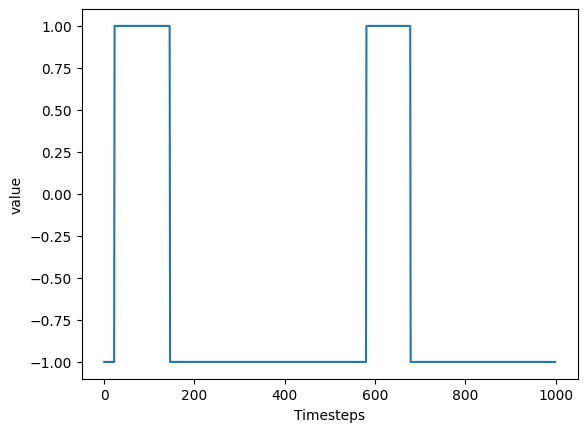

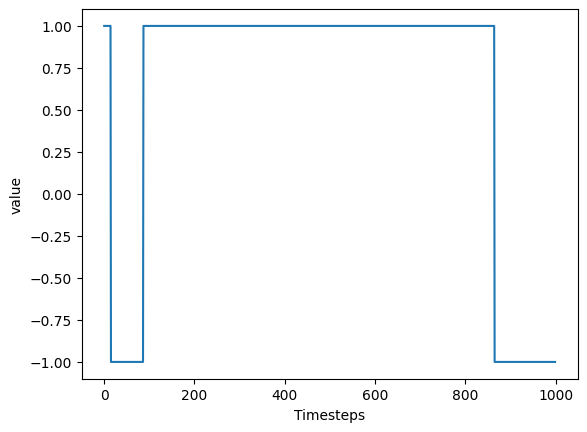

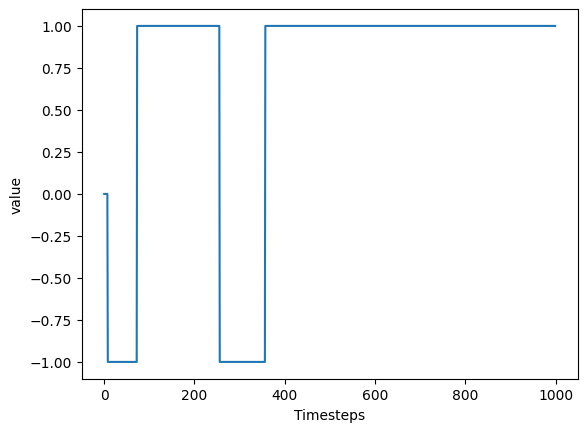

In [43]:
import matplotlib.pyplot as plt

class data_generation():
    def __init__(self, T, input_size, prob = 0.007, seed = 42):
        # We initialise the values: 
        self.T = T
        self.input_size = input_size
        self.prob = prob
        self.seed = seed
    
    def generate_flipflop_input(self):
        torch.manual_seed(self.seed)

        # Initialise the input for the RNN
        input_tensor = torch.zeros((self.T, self.input_size), dtype=torch.float32)

        # Initial value: randomly chosen for each input bit from {-1, 0, 1}
        current = torch.randint(low=-1, high=2, size=(self.input_size,), dtype=torch.int)

        for t in range(self.T):
            if t > 0:
                # Carry over previous values
                current = input_tensor[t - 1].clone().to(torch.int)

            # Decide which bits to change
            change_mask = torch.rand(self.input_size) < self.prob

            for i in range(self.input_size):
                if change_mask[i]:
                    # Pick a new value that's different from the current one
                    possible = [-1, 0, 1]
                    possible.remove(int(current[i].item()))
                    new_value = possible[torch.randint(len(possible), (1,)).item()]
                    current[i] = new_value

            input_tensor[t] = current

        return input_tensor
    
    def generate_flipflop_target(self, input_tensor):
        target_tensor = torch.zeros_like(input_tensor)
        current = torch.zeros(self.input_size)

        for t in range(self.T):
            mask = input_tensor[t] != 0
            current[mask] = input_tensor[t][mask]
            target_tensor[t] = current

        return target_tensor

    def visualise_data(self, data):
        for i in range(3):
            plt.xlabel("Timesteps")
            plt.ylabel("value")
            plt.plot(data[:, i]) 
            plt.show()

data = data_generation(1000, 3)
df = data.generate_flipflop_input()
#data.visualise_data(df)

df2 = data.generate_flipflop_target(df)
data.visualise_data(df2)



## Training the RNN

In [44]:
T = 1000
input_size = 3

# Initialise the data
data = data_generation(T, input_size, prob=0.01)
inputs = data.generate_flipflop_input()
targets = data.generate_flipflop_target(inputs)



hidden_size = 1000

model = flipflop(input_size=input_size, hidden_size=hidden_size, output_size=input_size)

# Run forward pass
outputs = model(inputs, targets) 




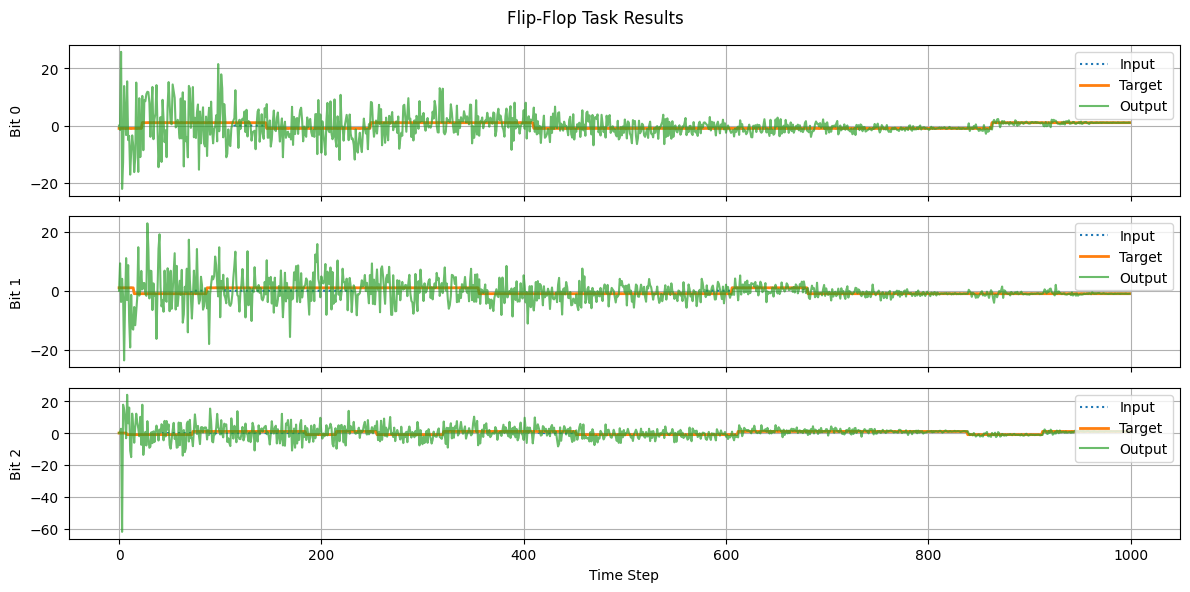

In [45]:
import matplotlib.pyplot as plt

def plot_flipflop(inputs, targets, outputs, title='Flip-Flop Task Results', bits=[0, 1, 2]):
    T = inputs.shape[0]
    time = torch.arange(T)

    fig, axs = plt.subplots(len(bits), 1, figsize=(12, 6), sharex=True)
    
    for i, b in enumerate(bits):
        axs[i].plot(time, inputs[:, b].cpu(), label='Input', linestyle='dotted')
        axs[i].plot(time, targets[:, b].cpu(), label='Target', linewidth=2)
        axs[i].plot(time, outputs[:, b].detach().cpu(), label='Output', alpha=0.7)
        axs[i].set_ylabel(f'Bit {b}')
        axs[i].legend(loc='upper right')
        axs[i].grid(True)

    axs[-1].set_xlabel('Time Step')
    fig.suptitle(title)
    plt.tight_layout()
    plt.show()

plot_flipflop(inputs, targets, outputs)


## Finding the Fixed points: 

In [50]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
import torch.nn.functional as F
from torch.optim import Adam
from sklearn.metrics.pairwise import cosine_distances
import numpy as np

class find_fixed_points():
    '''
    Ok the whole point of this class is going to be to minimise: 
    ||dx/dt||^2 = ||-x + J*r + B*u + W_fb*z||^2

    We are going to approximate teh differentation using a finite difference and simulate the dynamics using Euler integration. 
    '''         
    def find_fixed_point(self, model, u=None, x_init=None, steps=1000, lr=1e-2, tol=1e-6, verbose=True):
        """
        Finds a fixed point of the RNN given an initial state and input.
        
        Args:
            model: your trained flipflop model
            u: constant input [input_size] or None (defaults to zero input)
            x_init: initial hidden state guess [hidden_size]
            steps: max number of optimization steps
            lr: learning rate
            tol: early stopping threshold on loss
            verbose: print loss info

        Returns:
            x_fixed: hidden state at fixed point
            z_fixed: output at fixed point
            loss_history: list of loss values
        """
        device = next(model.parameters()).device
        hidden_size = model.hidden_size
        input_size = model.input_size
        output_size = model.output_size

        # Use zero input if not specified
        if u is None:
            u = torch.zeros(input_size, device=device)

        # Start from random or provided x_init
        if x_init is None:
            x = torch.randn(hidden_size, device=device, requires_grad=True)
        else:
            x = x_init.clone().detach().to(device).requires_grad_()

        optimizer = Adam([x], lr=lr)
        loss_history = []

        for i in range(steps):
            optimizer.zero_grad()

            r = torch.tanh(x)
            z = model.W_out.T @ r
            dx = -x + model.J @ r + model.B @ u + model.W_fb @ z

            loss = torch.norm(dx) ** 2
            loss.backward()
            optimizer.step()

            loss_history.append(loss.item())

            if verbose and i % 100 == 0:
                print(f"Step {i}: Loss = {loss.item():.4e}")

            if loss.item() < tol:
                if verbose:
                    print(f"Converged at step {i} with loss {loss.item():.4e}")
                break

        # Final values
        x_fixed = x.detach()
        r_fixed = torch.tanh(x_fixed)
        z_fixed = model.W_out.T @ r_fixed

        return x_fixed, z_fixed.detach(), loss_history

    def plot_trajectory_and_fixed_point(slef, traj_3d, fixed_3d):
        fig = plt.figure(figsize=(10, 7))
        ax = fig.add_subplot(111, projection='3d')

        # Plot RNN trajectory
        ax.plot(traj_3d[:, 0], traj_3d[:, 1], traj_3d[:, 2], label='Trajectory', linewidth=1.5)

        # Plot fixed point
        ax.scatter(*fixed_3d, color='red', s=100, label='Fixed Point', marker='x')

        ax.set_title("RNN Hidden State Trajectory + Fixed Point (PCA 3D)")
        ax.set_xlabel("PC 1")
        ax.set_ylabel("PC 2")
        ax.set_zlabel("PC 3")
        ax.legend()
        plt.tight_layout()
        plt.show()

    def find_many_fixed_points(self, model, u=None, n_inits=50, threshold=1e-2, verbose=False):
        """
        Repeatedly finds fixed points from different random initial conditions.
        
        Returns:
            fixed_points: list of (x*, z*) tuples
        """
        all_x_fixed = []
        all_z_fixed = []

        for i in range(n_inits):
            x_init = torch.randn(model.hidden_size)
            x_star, z_star, _ = self.find_fixed_point(model, u=u, x_init=x_init, verbose=False)
            x_np = x_star.cpu().numpy()

            # Check if this fixed point is unique (not within threshold of others)
            is_unique = True
            for existing in all_x_fixed:
                dist = np.linalg.norm(x_np - existing.cpu().numpy())
                if dist < threshold:
                    is_unique = False
                    break

            if is_unique:
                if verbose:
                    print(f"Found unique fixed point #{len(all_x_fixed)+1}")
                all_x_fixed.append(x_star)
                all_z_fixed.append(z_star)

        return all_x_fixed, all_z_fixed


Found unique fixed point #1
Found unique fixed point #2
Found unique fixed point #3
Found unique fixed point #4
Found unique fixed point #5
Found unique fixed point #6
Found unique fixed point #7
Found unique fixed point #8
Found unique fixed point #9
Found unique fixed point #10
Found unique fixed point #11
Found unique fixed point #12
Found unique fixed point #13
Found unique fixed point #14
Found unique fixed point #15
Found unique fixed point #16
Found unique fixed point #17
Found unique fixed point #18
Found unique fixed point #19
Found unique fixed point #20
Found unique fixed point #21
Found unique fixed point #22
Found unique fixed point #23
Found unique fixed point #24
Found unique fixed point #25
Found unique fixed point #26
Found unique fixed point #27
Found unique fixed point #28
Found unique fixed point #29
Found unique fixed point #30
Found unique fixed point #31
Found unique fixed point #32
Found unique fixed point #33
Found unique fixed point #34
Found unique fixed poin

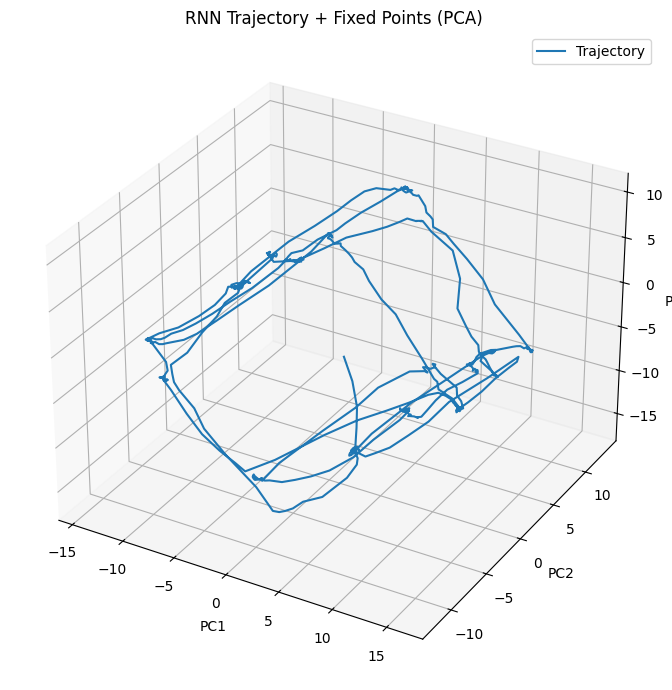

In [52]:
from sklearn.decomposition import PCA

# Generate data
T = 1000
input_tensor = data.generate_flipflop_input().to(model.W_out.device)
target_tensor = data.generate_flipflop_target(input_tensor)

# Run model and collect hidden states
outputs, hidden_states = model(input_tensor, target_tensor, collect_states=True)

# Find a fixed point (optional: use same input u as a row of your input_tensor)
u = input_tensor[500]
fixed = find_fixed_points()
x_fixed_list, z_fixed_list = fixed.find_many_fixed_points(model, u=u, n_inits=100, threshold=1e-2, verbose=True)

print(f"Found {len(x_fixed_list)} unique fixed points.")

# Stack fixed points and hidden states
all_fixed = torch.stack(x_fixed_list)
all_points = torch.cat([hidden_states, all_fixed], dim=0).cpu().numpy()

# PCA
pca = PCA(n_components=3)
points_3d = pca.fit_transform(all_points)
traj_3d = points_3d[:len(hidden_states)]
fixed_3d = points_3d[len(hidden_states):]

# Plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot(traj_3d[:, 0], traj_3d[:, 1], traj_3d[:, 2], label='Trajectory', linewidth=1.5)
#ax.scatter(fixed_3d[:, 0], fixed_3d[:, 1], fixed_3d[:, 2], color='red', s=80, label='Fixed Points', marker='x')
ax.set_title("RNN Trajectory + Fixed Points (PCA)")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.legend()
plt.tight_layout()
plt.show()



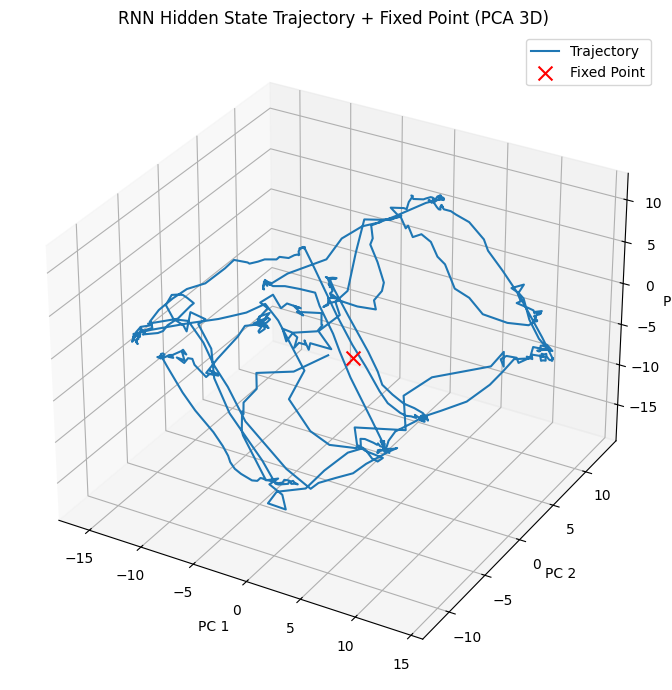

In [48]:
fixed.plot_trajectory_and_fixed_point(traj_3d, fixed_3d)


In [49]:
input_tensor[500]

tensor([-1., -1., -1.])